# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:05:27.596578
Mem. usage decreased to 1478.92 Mb (15.1% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Price,Season_Year,Vendor_ID,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7871884,47,2020,2020W47,101,1289328500,4.0,56.090000,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7871885,47,2020,2020W47,101,1289328600,2.0,29.799999,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7871886,47,2020,2020W47,101,1289328700,5.0,32.869999,6.57,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7871887,47,2020,2020W47,101,1289328800,4.0,27.600000,6.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Classify Data

Current Classification (A: Top-Seller, B: Medium-Seller, C: Low-Seller)

A:
At least one in 6 different weeks & mean sales per week greater 0.3

B:
At least one in 6 different weeks & mean sales per week greater 0.1

C:
All the rest


In [6]:
df['Classification'] = 'C'

for i, g in df.groupby(['Site_ID', 'SKU']):
    
    if  (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.4):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'A'
        
    elif (g.Sales_QTY[g.Sales_QTY > 0].count() > 5) & (g.Sales_QTY[g.Sales_QTY > 0].count() / g.Sales_QTY.count() > 0.1):
        df.iloc[list(g.index), df.columns.get_loc('Classification')] = 'B'

        
# Print summary: number of Time-Series per Classification
df[['Site_ID', 'SKU', 'Classification']].drop_duplicates()[['Classification']].value_counts()

Classification
C                 32930
B                 21528
A                  5416
dtype: int64

# Plot Time Series

In [7]:
n_series = 8

In [8]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of lists with Site ID - Article combinations to be vizualized.
            Example: [['g590', 1282277826], ['g115', 1254150002], ['g102', 1264627019]]
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for site, article in samples:
        df_article = sales.loc[df.SKU == article].loc[df.Site_ID == site].sort_values(by='Date').reset_index()

        df_article.plot(x='Date',
                     y='Sales_QTY',
                     title= f'SKU: {article}, Site ID: {site}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

## Class A (Top Seller)

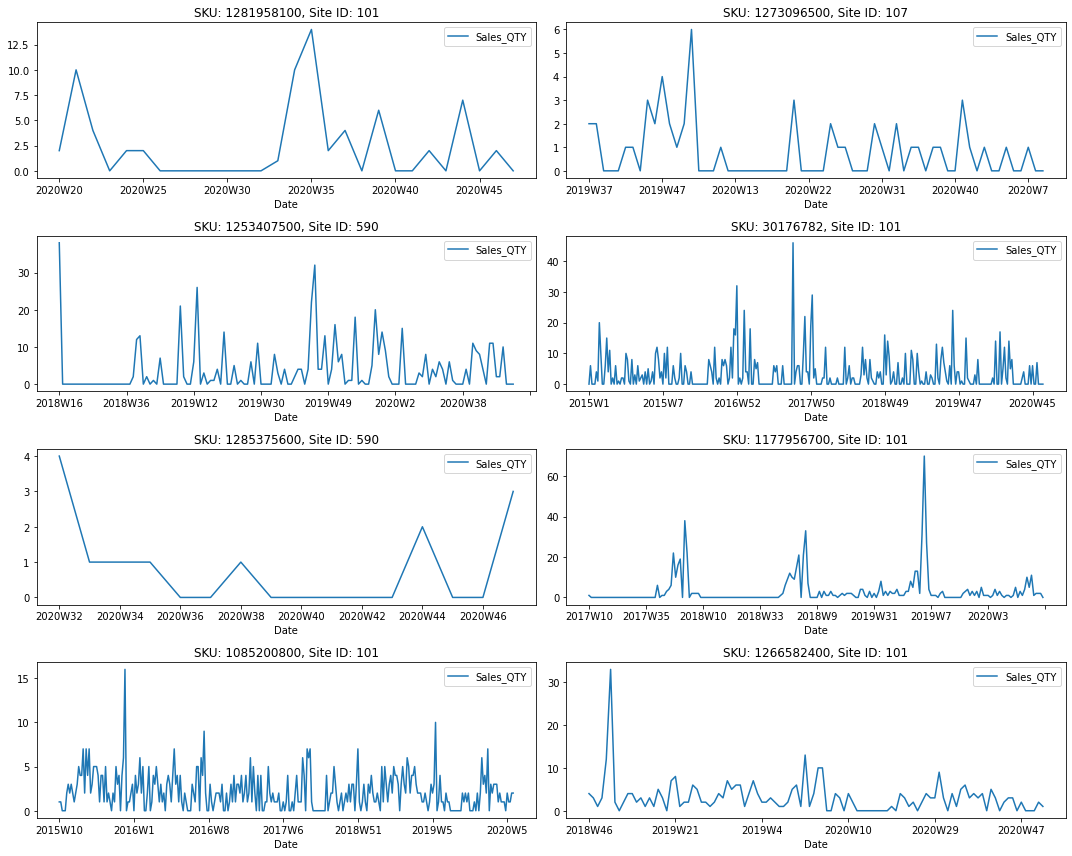

In [9]:
classification = 'A'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class B (Medium Seller)

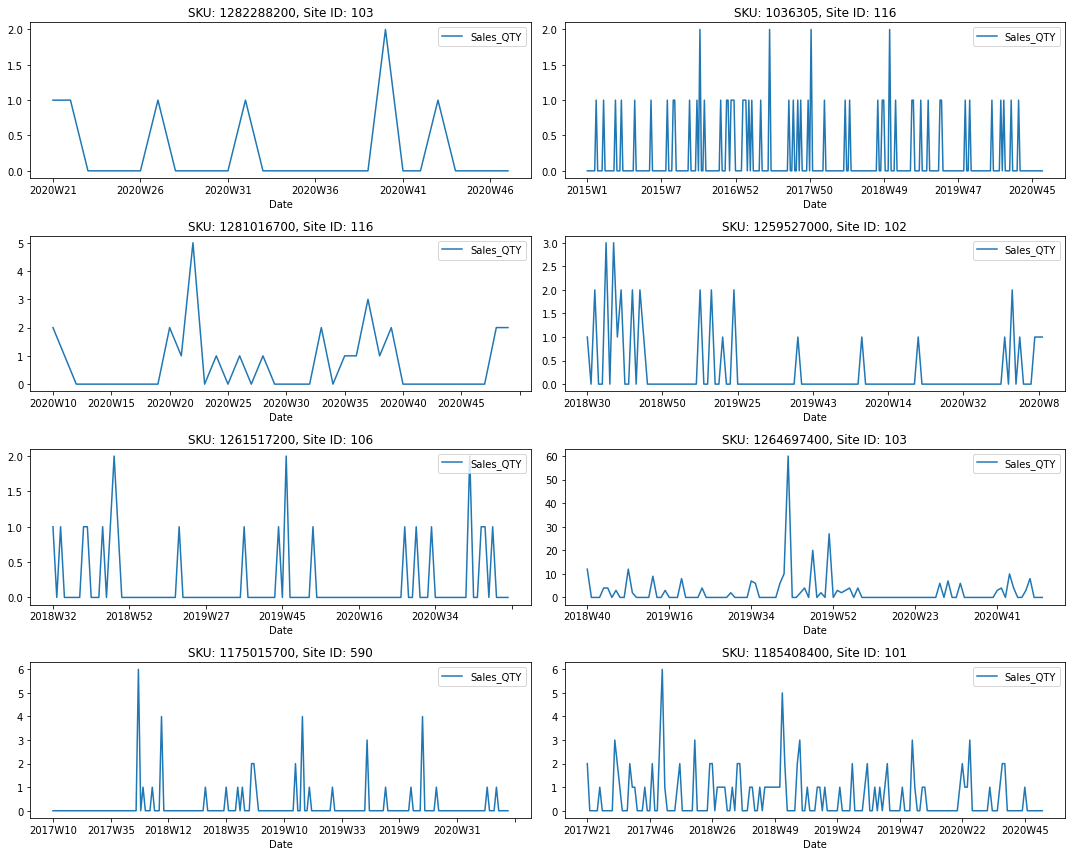

In [10]:
classification = 'B'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

## Class C (Low Seller)

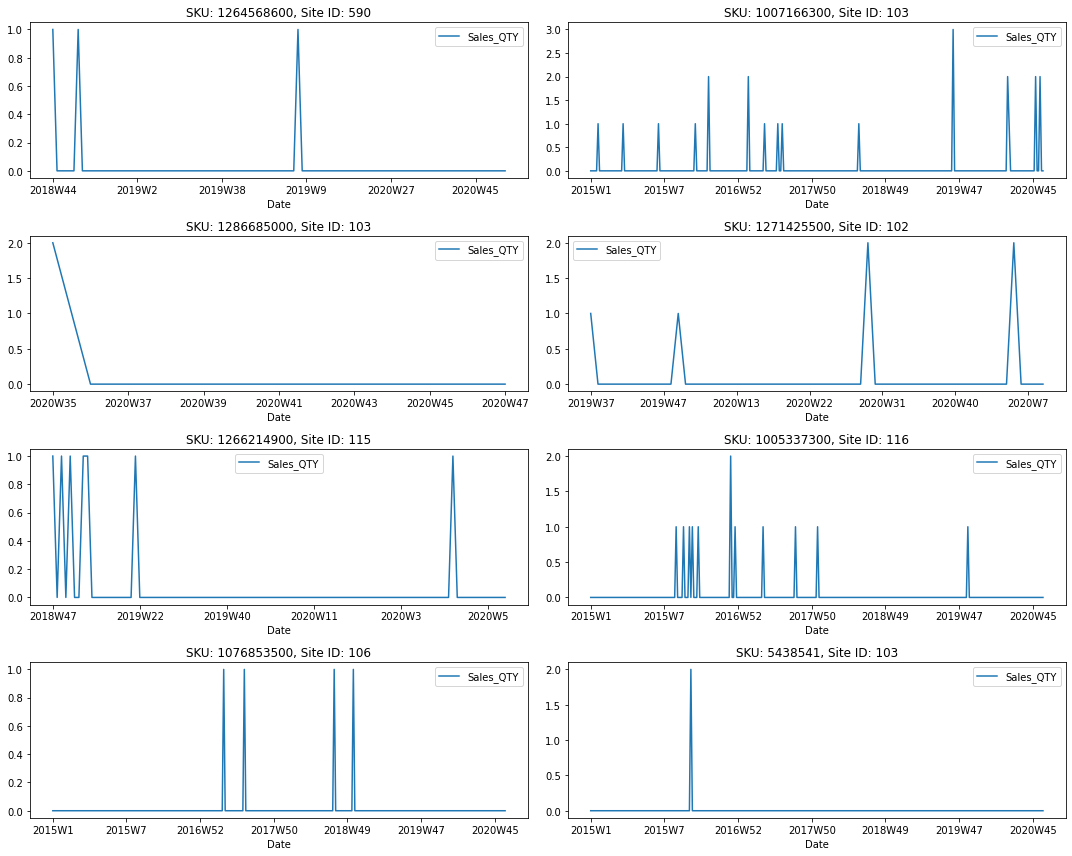

In [11]:
classification = 'C'
samples = df.loc[df.Classification == classification][['Site_ID','SKU']].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()
plot_timeseries(samples, df)

# Feature Engineering

In [12]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [13]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [14]:
# Convert categorical features to integers 
df, encoders_dict = utils.encode_categorical(df, cat_features, return_encoders = True)

# Forecasting

In [15]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [16]:
# Store results in dataframe and validate the error at the end.
result_df = pd.DataFrame(columns=['Week', 'Year', 'Site_ID', 'SKU','Prediction']+[target_variable])

In [17]:
split_criteria = 'CENSHARE_CAT_1'

df[[split_criteria]].value_counts()

CENSHARE_CAT_1
9                 2081448
15                1574506
13                 914265
0                  831247
2                  728690
16                 719805
6                  308590
11                 244995
14                 201051
4                   81070
17                  67397
12                  49070
3                   31894
10                  22208
8                   12001
1                    2095
7                    1148
5                     409
dtype: int64

## Class A (Top Seller)

In [18]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [19]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {split} ******')
        
        df_class = df.loc[df.Classification == 'A'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()



****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 7 ******


****** 5W45 ******
****** Split Criteria: CENSHARE_CAT_1 = 5 ******


In [20]:
print('RMSE:\n', rmse)
    
print('\nMean RMSE: ', np.mean(rmse))

RMSE:
 [52.43539918567698, 72.63887920344193, 94.98191358124667, 39.738221753493654, 8.032890389606608, 112.1106322818754, 107.17101414980753, 18.139886054199714, 48.965778595546176, 101.32046941759543, 23.91535330397752, 58.61601901721515, 48.852639880439455, 226.09052794280436, 46.734052063963446, 9.737891209948547]

Mean RMSE:  66.84259800192741


In [21]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,30.868194,29.900000
3034,46,5,0,1,24.796745,0.000000
5409,46,5,0,2,56.998503,0.000000
6641,46,5,4,2,53.501745,0.000000
7865,46,5,8,2,55.250172,0.000000
...,...,...,...,...,...,...
7861425,46,5,5,9046,26.423091,14.900000
7861439,46,5,6,9046,46.992285,119.199997
7861452,46,5,7,9046,24.360941,14.900000
7861465,46,5,8,9046,65.190063,14.900000


## Class B (Medium Seller)

In [22]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [23]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {split} ******')
        
        df_class = df.loc[df.Classification == 'B'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()

In [24]:
print('RMSE:\n', rmse)
    
print('\nMean RMSE: ', np.mean(rmse))

RMSE:
 [78.81633108159059, 59.07257951503721, 79.62891969431551, 28.05244102144142, 29.460903013388563, 99.38310136004573, 44.4307648975749, 23.221096872794256, 68.23203491654922, 71.21558647327535, 24.17218068147209, 26.867900557217677, 139.38729141075171, 81.59588777604576, 10.111456099854431, 8.55374358654319, 111.94088355268073, 10.784700772270257]

Mean RMSE:  55.27376684904715


In [25]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,30.868194,29.9
3034,46,5,0,1,24.796745,0.0
5409,46,5,0,2,56.998503,0.0
6641,46,5,4,2,53.501745,0.0
7865,46,5,8,2,55.250172,0.0
...,...,...,...,...,...,...
6714282,46,5,8,3960,9.594087,0.0
7700749,46,5,0,7373,5.984377,0.0
7700849,46,5,2,7373,5.984377,24.9
7700917,46,5,4,7373,5.984377,0.0


## Class C (Low Seller)

In [26]:
rmse = []



save_models = False

for week, year in splits:
    for split in df[split_criteria].drop_duplicates():
        print(f'\n\n****** {year}W{week} ******')
        print(f'****** Split Criteria: {split_criteria} = {split} ******')
        
        df_class = df.loc[df.Classification == 'C'].loc[df[split_criteria] == split].copy()
        if df_class.empty:
            continue
        
        evals_result = {}

        week=int(week)
        year=int(year)

        # Train data: same year and past week OR past year
        x_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][features]
        y_train = df_class.loc[((df_class.Year == (Week(year, week))[0]) & (df_class.Week <= (Week(year, week))[1])) | (df_class.Year < (Week(year, week))[0])][target_variable]

        x_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][features]
        y_test = df_class.loc[df_class.Year == (Week(year, week)+1)[0]].loc[df_class.Week == (Week(year, week)+1)[1]][target_variable]



        train_data = lgb.Dataset(x_train, label=y_train,
                                 categorical_feature=cat_features, free_raw_data=False,
                               )
        validation_data = lgb.Dataset(
            x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
        )



        gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                        evals_result=evals_result, num_boost_round=1000,
                        verbose_eval=25, early_stopping_rounds=20,
                       )


        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)


        if save_models:
            print('log: save model and evals result')
            gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 

            evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
            pickle.dump(evals_result, evals_result_p)
            evals_result_p.close()

        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        # Gather results of this article category and store them in general result_df
        result_class = x_test[['Week', 'Year', 'Site_ID', 'SKU']].copy()
        result_class[target_variable] = list(y_test)
        result_class['Prediction'] = list(y_pred)


        result_df = result_df.append(result_class)
        
        # Clear Cell Output
        clear_output()

In [27]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [154.89966968309628, 39.07780299486122, 53.7499532918781, 22.139749110694208, 17.434297421709065, 88.49178482773861, 36.740814484835056, 14.30340362914209, 39.69099439704542, 64.05496117658376, 22.824229948676624, 39.746379775022874, 89.64660765383486, 69.78485326170173, 66.10581423575681, 0.009697341821831079, 0.7679116741460678]

Crossvalidated RMSE:  48.20405440638497


In [28]:
result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,46,5,0,0,30.868194,29.9
3034,46,5,0,1,24.796745,0.0
5409,46,5,0,2,56.998503,0.0
6641,46,5,4,2,53.501745,0.0
7865,46,5,8,2,55.250172,0.0
...,...,...,...,...,...,...
7700799,46,5,1,7373,0.767912,0.0
7700867,46,5,3,7373,0.767912,0.0
7700967,46,5,5,7373,0.767912,0.0
7701058,46,5,7,7373,0.767912,0.0


## Validate Overall Performance

In [29]:
mean_squared_error(result_df.Prediction, result_df.Turnover, squared=False)

77.87845301806087

# Save Results

In [30]:
# Cast Data Types before decoding
result_df = result_df.astype({'Week': 'int8','Year': 'int8','Site_ID': 'int8','SKU': 'int32'})

# Decode Categorical Variables
result_df = utils.decode_categorical(result_df, encoders_dict)

# save
result_df.to_csv('forecasts/forecasts.csv', index=False)

result_df

,Week,Year,Site_ID,SKU,Prediction,Turnover
307,47,2020,101,1014557,30.868194,29.9
3034,47,2020,101,1014824,24.796745,0.0
5409,47,2020,101,1016525,56.998503,0.0
6641,47,2020,107,1016525,53.501745,0.0
7865,47,2020,590,1016525,55.250172,0.0
...,...,...,...,...,...,...
7700799,47,2020,102,1281324700,0.767912,0.0
7700867,47,2020,106,1281324700,0.767912,0.0
7700967,47,2020,115,1281324700,0.767912,0.0
7701058,47,2020,117,1281324700,0.767912,0.0
